## Author
# Przemysław Kuta

The data is related with direct marketing campaigns of a Portuguese banking institution. 
The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
in order to access if the product (bank term deposit) would be (or not) subscribed. 

#  The classification goal is to predict if the client will subscribe a term deposit (variable y).

In [1]:
#Importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

 # bank client data:
   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
                                       
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   
   5 - default: has credit in default? (binary: "yes","no")
   
   6 - balance: average yearly balance, in euros (numeric) 
   
   7 - housing: has housing loan? (binary: "yes","no")
   
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
   
  10 - day: last contact day of the month (numeric)
  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  
  12 - duration: last contact duration, in seconds (numeric)
   # other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  
  17 - y / deposit - has the client subscribed a term deposit? (binary: "yes","no")

In [2]:
df = pd.read_csv('bank.csv')
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [3]:
# cleaning full dataset - removing unnecessary characters
with open('bank-full.csv','r') as input_file, open('bank-full-cleared.csv','w') as output_file:
    raw_text = input_file.read()
    raw_text = raw_text.replace('"','')
    output_file.write(raw_text)
df_full = pd.read_csv('bank-full-cleared.csv', sep=';')

# quick fix of incompatible column names
df_full.rename(columns={"y": "deposit"}, inplace=True)

In [4]:
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

## Basic EDA

In [5]:
#df.describe()

In [6]:
#df.info()

In [7]:
# Basic overview of the numerical data relation with hue on y label
# no relevant graphical relation found
# g = sns.PairGrid(df, hue='deposit')
# g.map_diag(sns.histplot, bins=10)
# g.map_lower(sns.scatterplot)
# g.add_legend()

In [8]:
#df_full.info()

Let's check correlation between small and full dataset

In [9]:
df_merge = pd.merge(df_full, df, how='left', indicator=True)
df_merge['_merge'].value_counts()

left_only     34049
both          11162
right_only        0
Name: _merge, dtype: int64

It appears that small dataset is a subset of bigger one.
Below I check positive values presence:

In [10]:
df_merge['_merge'][df_merge['deposit']=='yes'].value_counts()

both          5289
left_only        0
right_only       0
Name: _merge, dtype: int64

It appears that all positive values are in the small subset. The smaller dataset is not a random subset of full dataset, but the undersampled dataset in order to get more balanced data, better for fitting ML algorithms.
I cannot use them after fitting algorithm, except of data in test subset.
Let's create subset of unique records (not visible in small subset). It will be combined with test dataset for evaluation.

In [11]:
df_uniques = df_merge[df_merge['_merge']=='left_only'].drop('_merge', axis=1)

In [12]:
#df_uniques.head()

## Date values analysis
Does it make sense to use it?

In [13]:
from datetime import date
import calendar

In [14]:
#generating dictionary in order to convert month names to numbers
month_map = {month.lower(): index for index, month in enumerate(calendar.month_abbr) if month}
df['month_num'] = df['month'].map(month_map)

In [15]:
# checking the occurence of a weekdays in data
df['weekday'] = df.apply(lambda x : date(2011, x['month_num'], x['day']).weekday(), axis=1) 

<AxesSubplot:xlabel='month', ylabel='count'>

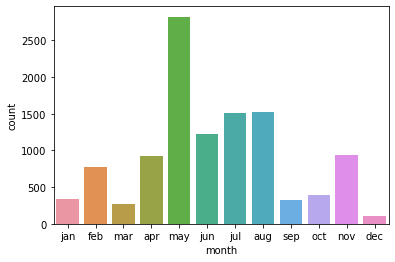

In [16]:
# month distribution (with respect to order them in correct order)
sns.countplot(data= df, x='month', order= month_map.keys())

<AxesSubplot:xlabel='weekday', ylabel='Count'>

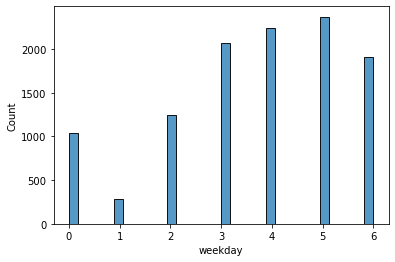

In [17]:
# weekday distribution
sns.histplot(data= df, x='weekday')

<AxesSubplot:xlabel='day', ylabel='Count'>

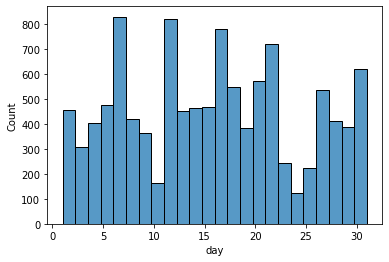

In [18]:
# day distribution
sns.histplot(data= df, x='day')

## Conclusion for date data
This date informations seems to not provide any valuable data.
1. records are not evenly distributed among months, so this offer have probably we promoted in some selected time frames
2. Assuming that calling were done on workdays (mon-fri), we cannot distinguish particular year when bank have offered it to customers. That is visible when refering to 'weekdays' graph.
3. Based on 'day' graph, it is also not evenly distributed, what suggests that data was not gathered among many years.

I expect that offer was on since May of one year till the end of May in the following year.
That gives me no chance to i.e. sort those data chronologically, therefore I will drop such data as irrelevant.
'Month' as a quite simple categorical data, might be useful to refer somehow to seasons of the year.

In [19]:
df.drop(['day','month_num','weekday'], axis=1, inplace=True)

In [20]:
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

  month  duration  campaign  pdays  previous poutcome deposit  
0   may      1042         1     -1         0  unknown     yes  
1   may      1467         1     -1         0  unknown     yes  
2   may      1389         1     -1         0  unknown     yes  
3   may       579         1     -1         0  unknown     yes  
4   may       673         2     -1         0  unknown     yes

## EDA

In [21]:
# creating separated dataframe for categories
df_categorical = df.select_dtypes(exclude=['int64'])
df_categorical.head()

job  marital  education default housing loan  contact month  \
0      admin.  married  secondary      no     yes   no  unknown   may   
1      admin.  married  secondary      no      no   no  unknown   may   
2  technician  married  secondary      no     yes   no  unknown   may   
3    services  married  secondary      no     yes   no  unknown   may   
4      admin.  married   tertiary      no      no   no  unknown   may   

  poutcome deposit  
0  unknown     yes  
1  unknown     yes  
2  unknown     yes  
3  unknown     yes  
4  unknown     yes

In [22]:
# handling output values - most of algorithms requires integer, not string for predictions
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

In [23]:
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

  month  duration  campaign  pdays  previous poutcome deposit  
0   may      1042         1     -1         0  unknown     yes  
1   may      1467         1     -1         0  unknown     yes  
2   may      1389         1     -1         0  unknown     yes  
3   may       579         1     -1         0  unknown     yes  
4   may       673         2     -1         0  unknown     yes

In [24]:
if ('deposit' in df.columns):
    df['output'] = lb.fit_transform(df['deposit'])
    df.drop('deposit', axis=1, inplace= True)
    print("Initial 'deposit' column removed.\n")
elif ('output' in df.columns):
    print("Initial 'deposit' column already removed.\nWork on 'output' column instead.\n\n")
print("Output labels with it's values:")
for (index, value) in enumerate(lb.classes_):
    print (f"{index} is treated as '{value}'.")

Initial 'deposit' column removed.

Output labels with it's values:
0 is treated as 'no'.
1 is treated as 'yes'.


<AxesSubplot:>

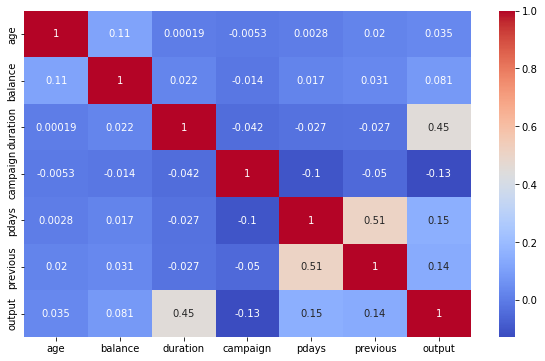

In [25]:
# checking correlation between numerical columns
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap='coolwarm', annot= True)

From the heatmap above we can see that when contact with customer was longer, they are more likely to agree for subscribing for a term deposit. Probably, they were asking for more details of this offer.
People with which we tend to contact more than once are also more eager to subscribe.

In [26]:
from sklearn.preprocessing import OneHotEncoder

In [27]:
ohe = OneHotEncoder(drop = None) #for the purpose of visualisation, I do not drop any of labels

In [28]:
arr_enc = ohe.fit_transform(np.array(df_categorical))
ohe.get_feature_names_out(df_categorical.columns)
df_enc = pd.DataFrame(arr_enc.toarray(), columns= ohe.get_feature_names_out(df_categorical.columns))

In [29]:
df_enc.head()

job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0         1.0              0.0               0.0            0.0   
1         1.0              0.0               0.0            0.0   
2         0.0              0.0               0.0            0.0   
3         0.0              0.0               0.0            0.0   
4         1.0              0.0               0.0            0.0   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0             0.0          0.0                0.0           0.0          0.0   
1             0.0          0.0                0.0           0.0          0.0   
2             0.0          0.0                0.0           0.0          0.0   
3             0.0          0.0                0.0           1.0          0.0   
4             0.0          0.0                0.0           0.0          0.0   

   job_technician  ...  month_may  month_nov  month_oct  month_sep  \
0             0.0  ...        1.0        0.0        0.0        0.0   
1             0.0  ...        1.0        0.0        0.0        0.0   
2             1.0  ...        1.0        0.0        0.0        0.0   
3             0.0  ...        1.0        0.0        0.0        0.0   
4             0.0  ...        1.0        0.0        0.0        0.0   

   poutcome_failure  poutcome_other  poutcome_success  poutcome_unknown  \
0               0.0             0.0               0.0               1.0   
1               0.0             0.0               0.0               1.0   
2               0.0             0.0               0.0               1.0   
3               0.0             0.0               0.0               1.0   
4               0.0             0.0               0.0               1.0   

   deposit_no  deposit_yes  
0         0.0          1.0  
1         0.0          1.0  
2         0.0          1.0  
3         0.0          1.0  
4         0.0          1.0  

[5 rows x 46 columns]

<AxesSubplot:>

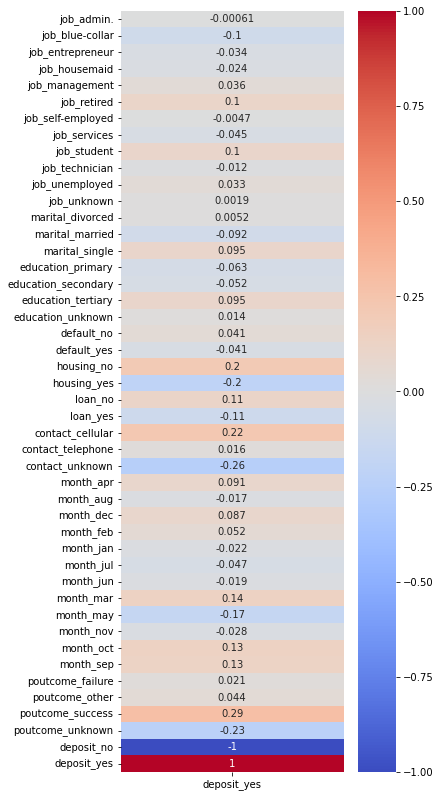

In [30]:
plt.figure(figsize=(5,14))
sns.heatmap(df_enc.corr()[['deposit_yes']], cmap='coolwarm', annot= True)

It seems like we have 3 key factors in categorical data.
- poutcome
- contact
- housing

It is not fully clear what is the influence of 'job' as long as it has many categories.
I will show it on other graph.

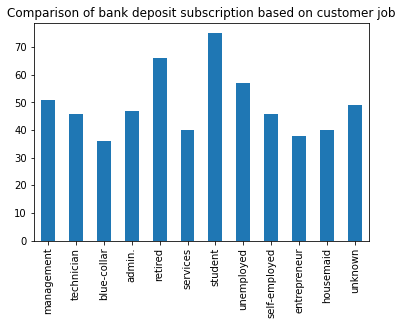

In [31]:
jobs = pd.DataFrame()
jobs['pos'] = df['job'][df['output']==1].value_counts()
jobs['all'] = df['job'].value_counts()

jobs['percentage']= round(jobs['pos']/jobs['all']*100)
jobs['percentage'].plot(kind = 'bar', title ='Comparison of bank deposit subscription based on customer job')
plt.show()

Customers with higher values tends more likely to subscribe for bank deposit. (Student, retired)

Those with smaller values, have smaller chance to successfuly subscribe( blue-collar, services, entrepreneur, housemaid)

# Building the model

In [32]:
ohe = OneHotEncoder(drop = 'first') #for the purpose of learning, I drop first label to prevent overfitting
arr_enc = ohe.fit_transform(np.array(df_categorical))
df_enc = pd.DataFrame(arr_enc.toarray(), columns= ohe.get_feature_names_out(df_categorical.columns))

if ('deposit' in df.columns):
    df.drop('deposit', axis = 1, inplace = True)
if ('deposit_yes' in df_enc.columns):
    df_enc.drop('deposit_yes', axis = 1, inplace = True)
if ('deposit_no' in df_enc.columns):
    df_enc.drop('deposit_no', axis = 1, inplace = True) 
df_enc.head()

job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0              0.0               0.0            0.0             0.0   
1              0.0               0.0            0.0             0.0   
2              0.0               0.0            0.0             0.0   
3              0.0               0.0            0.0             0.0   
4              0.0               0.0            0.0             0.0   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0          0.0                0.0           0.0          0.0             0.0   
1          0.0                0.0           0.0          0.0             0.0   
2          0.0                0.0           0.0          0.0             1.0   
3          0.0                0.0           1.0          0.0             0.0   
4          0.0                0.0           0.0          0.0             0.0   

   job_unemployed  ...  month_jul  month_jun  month_mar  month_may  month_nov  \
0             0.0  ...        0.0        0.0        0.0        1.0        0.0   
1             0.0  ...        0.0        0.0        0.0        1.0        0.0   
2             0.0  ...        0.0        0.0        0.0        1.0        0.0   
3             0.0  ...        0.0        0.0        0.0        1.0        0.0   
4             0.0  ...        0.0        0.0        0.0        1.0        0.0   

   month_oct  month_sep  poutcome_other  poutcome_success  poutcome_unknown  
0        0.0        0.0             0.0               0.0               1.0  
1        0.0        0.0             0.0               0.0               1.0  
2        0.0        0.0             0.0               0.0               1.0  
3        0.0        0.0             0.0               0.0               1.0  
4        0.0        0.0             0.0               0.0               1.0  

[5 rows x 35 columns]

In [33]:
df_final = df_enc.merge(df.select_dtypes(exclude=['object']), left_index = True, right_index=True )
df_final.head()

job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0              0.0               0.0            0.0             0.0   
1              0.0               0.0            0.0             0.0   
2              0.0               0.0            0.0             0.0   
3              0.0               0.0            0.0             0.0   
4              0.0               0.0            0.0             0.0   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0          0.0                0.0           0.0          0.0             0.0   
1          0.0                0.0           0.0          0.0             0.0   
2          0.0                0.0           0.0          0.0             1.0   
3          0.0                0.0           1.0          0.0             0.0   
4          0.0                0.0           0.0          0.0             0.0   

   job_unemployed  ...  poutcome_other  poutcome_success  poutcome_unknown  \
0             0.0  ...             0.0               0.0               1.0   
1             0.0  ...             0.0               0.0               1.0   
2             0.0  ...             0.0               0.0               1.0   
3             0.0  ...             0.0               0.0               1.0   
4             0.0  ...             0.0               0.0               1.0   

   age  balance  duration  campaign  pdays  previous  output  
0   59     2343      1042         1     -1         0       1  
1   56       45      1467         1     -1         0       1  
2   41     1270      1389         1     -1         0       1  
3   55     2476       579         1     -1         0       1  
4   54      184       673         2     -1         0       1  

[5 rows x 42 columns]

Firstly, I will check the most general models, like Random Forest.

In [34]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('output', axis=1), df_final['output'], test_size=0.25)

In [35]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [36]:
y_pred = rfc.predict(X_test)

In [37]:
print(accuracy_score(y_test,y_pred))

0.8394840558939448


In [38]:
# listing out the importance of features in fitting process
# Random forest prefers continous features than binarized
# for feature, importance in zip(X_train.columns, rfc.feature_importances_):
#     print(importance,":\t",feature)

In [39]:
print(confusion_matrix(y_test,y_pred))

[[1182  265]
 [ 183 1161]]


Let's try another algorithms.
SVC, Naive Bayes and KNN

In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
# from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier # these models were tested on small dataset, but with weak results

In [41]:
mms = MinMaxScaler()
mms.fit(df_final.drop('output', axis=1))
X_train_mms = pd.DataFrame(mms.transform(X_train))
X_test_mms =  pd.DataFrame(mms.transform(X_test))

parameters = {'kernel':('rbf', 'sigmoid'), 'C':[10, 1000, 10000]}

In [42]:
svc = SVC()
gcv = GridSearchCV(svc, parameters, n_jobs=-1, verbose = 3, scoring= 'f1')
mnb = MultinomialNB()
bnb = BernoulliNB(binarize=0.5)
knn = KNeighborsClassifier()

In [43]:
gcv.fit(X_train_mms, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [10, 1000, 10000], 'kernel': ('rbf', 'sigmoid')},
             scoring='f1', verbose=3)

In [44]:
mnb.fit(X_train_mms, y_train)

MultinomialNB()

In [45]:
bnb.fit(X_train_mms, y_train)

BernoulliNB(binarize=0.5)

In [46]:
knn.fit(X_train_mms, y_train)

KNeighborsClassifier()

In [47]:
y_gcv = gcv.predict(X_test_mms)
y_mnb = mnb.predict(X_test_mms)
y_bnb = bnb.predict(X_test_mms)
y_knn = knn.predict(X_test_mms)

In [48]:
print("Grid Search on SVC - with best params: ",accuracy_score(y_test,y_gcv))
print(gcv.best_estimator_)
print("\nMultinomialNB: ",accuracy_score(y_test,y_mnb))
print("\nBernouliiNB: ",accuracy_score(y_test,y_bnb))
print("\nKNN Classifier: ",accuracy_score(y_test,y_knn))

Grid Search on SVC - with best params:  0.8172697957721247
SVC(C=10)

MultinomialNB:  0.6929415979935507

BernouliiNB:  0.6829093514869222

KNN Classifier:  0.7635256180580438


**None of boosting methods** gave better results than KNN, SVC after GridSearch or Random Forest.
Therefore Voting classifier for these 3 models will be created.

In [49]:
from sklearn.ensemble import VotingClassifier
svc_cv = SVC(kernel = 'rbf', C= 10)
vot = VotingClassifier(estimators=[
        ('knn', knn), ('svc', svc_cv), ('rfc', rfc)], voting='hard')

In [50]:
vot.fit(X_train_mms, y_train)


VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svc', SVC(C=10)),
                             ('rfc',
                              RandomForestClassifier(n_estimators=500,
                                                     n_jobs=-1))])

In [51]:
y_vot = vot.predict(X_test_mms)
print("\nVoting Classifier: ",accuracy_score(y_test,y_vot))


Voting Classifier:  0.8283769258330348


## Conclusion
It appears that none of classifiers works better than common Random Forest Classifier. Even Voting model based on RFC shows smaller accuracy. 

## Final evaluation
I will merge unique dataset with testing samples in order to check performance of models on bigger ammount of data.

In [52]:
#all the following transformation were done through the entire project
df_uniques.drop(['day'], axis=1, inplace=True)
df_categorical = df_uniques.select_dtypes(exclude=['int64'])
df_uniques['output'] = lb.transform(df_uniques['deposit'])
df_uniques.drop('deposit', axis=1, inplace= True)

arr_enc = ohe.transform(np.array(df_categorical))
df_enc = pd.DataFrame(arr_enc.toarray(), columns= ohe.get_feature_names_out(df_categorical.columns))

if ('deposit_yes' in df_enc.columns):
    df_enc.drop('deposit_yes', axis = 1, inplace = True)
if ('deposit_no' in df_enc.columns):
    df_enc.drop('deposit_no', axis = 1, inplace = True) 
    
df_uniques_final = df_enc.merge(df_uniques.select_dtypes(exclude=['object']), left_index = True, right_index=True )
df_uniques_final.head()

job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0              0.0               0.0            0.0             1.0   
2              1.0               0.0            0.0             0.0   
3              0.0               0.0            0.0             0.0   
4              0.0               0.0            0.0             1.0   
5              0.0               0.0            0.0             1.0   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0          0.0                0.0           0.0          0.0             0.0   
2          0.0                0.0           0.0          0.0             0.0   
3          0.0                0.0           0.0          0.0             0.0   
4          0.0                0.0           0.0          0.0             0.0   
5          0.0                0.0           0.0          0.0             0.0   

   job_unemployed  ...  poutcome_other  poutcome_success  poutcome_unknown  \
0             0.0  ...             0.0               0.0               1.0   
2             0.0  ...             0.0               0.0               1.0   
3             0.0  ...             0.0               0.0               1.0   
4             0.0  ...             0.0               0.0               1.0   
5             0.0  ...             0.0               0.0               1.0   

   age  balance  duration  campaign  pdays  previous  output  
0   58     2143       261         1     -1         0       0  
2   33        2        76         1     -1         0       0  
3   47     1506        92         1     -1         0       0  
4   33        1       198         1     -1         0       0  
5   35      231       139         1     -1         0       0  

[5 rows x 42 columns]

In [53]:
X_test = pd.concat([X_test,df_uniques_final.drop('output', axis=1)], ignore_index=True)
y_test = pd.concat([y_test,df_uniques_final['output']], ignore_index=True)
X_test_mms =  pd.DataFrame(mms.transform(X_test))

In [54]:
y_rfc = rfc.predict(X_test)
y_gcv = gcv.predict(X_test_mms)
y_mnb = mnb.predict(X_test_mms)
y_bnb = bnb.predict(X_test_mms)
y_knn = knn.predict(X_test_mms)
y_vot = vot.predict(X_test_mms)

Due to fact that our data are imbalanced, it might be a good idea to compare all models based on other metrics

In [55]:
from sklearn.metrics import f1_score, recall_score

In [56]:
print("ML model algorithm\t\tf1_score\t\trecall_score\t\taccuracy_score")
print("Random Forest Classifier", f1_score(y_test,y_rfc), recall_score(y_test,y_rfc), accuracy_score(y_test,y_rfc), sep='\t')
print("Grid Search on SVC\t ", f1_score(y_test,y_gcv), recall_score(y_test,y_gcv), accuracy_score(y_test,y_gcv), sep='\t')
print("MultinomialNB\t\t ", f1_score(y_test,y_mnb), recall_score(y_test,y_mnb), accuracy_score(y_test,y_mnb), sep='\t')
print("BernouliiNB\t\t ", f1_score(y_test,y_bnb), recall_score(y_test,y_bnb), accuracy_score(y_test,y_bnb), sep='\t')
print("KNN Classifier\t\t ", f1_score(y_test,y_knn), recall_score(y_test,y_knn), accuracy_score(y_test,y_knn), sep='\t')
print("Voting Classifier\t ", f1_score(y_test,y_vot), recall_score(y_test,y_vot), accuracy_score(y_test,y_vot), sep='\t')

ML model algorithm		f1_score		recall_score		accuracy_score
Random Forest Classifier	0.3361320208453967	0.8638392857142857	0.8469496729408623
Grid Search on SVC	 	0.3235769966171496	0.8184523809523809	0.8465158189827794
MultinomialNB		 	0.20801787265731664	0.6235119047619048	0.7870444533440129
BernouliiNB		 	0.18099452170248634	0.6391369047619048	0.7405553330663462
KNN Classifier		 	0.2513007284079084	0.71875	0.8079028167133894
Voting Classifier	 	0.3329889298892989	0.8392857142857143	0.8491856894940596


In [57]:
print("Random Forest Classifier:\n", confusion_matrix(y_test,y_rfc))
print("Grid Search on SVC:\n ", confusion_matrix(y_test,y_gcv))
print("MultinomialNB:\n ", confusion_matrix(y_test,y_mnb))
print("BernouliiNB:\n ", confusion_matrix(y_test,y_bnb))
print("KNN Classifier:\n ", confusion_matrix(y_test,y_knn))
print("Voting Classifier:\n ", confusion_matrix(y_test,y_vot))

Random Forest Classifier:
 [[24217  4403]
 [  183  1161]]
Grid Search on SVC:
  [[24265  4355]
 [  244  1100]]
MultinomialNB:
  [[22745  5875]
 [  506   838]]
BernouliiNB:
  [[21331  7289]
 [  485   859]]
KNN Classifier:
  [[23242  5378]
 [  378   966]]
Voting Classifier:
  [[24317  4303]
 [  216  1128]]


SVC algorithm gives us a possibility to tune Precision-Recall Tradeoff by decision_function() method. Therefore, we can change business logic of the output. I do not try to predict one to one who is going to subscribe or not for a bank deposit.
I will try to distinguish people with higher chance of subscription from those, who are not likely to do that.

In [58]:
svc_cv.fit(X_train_mms,y_train)

SVC(C=10)

In [59]:
y_svc_dec = svc_cv.decision_function(X_test_mms)

In [60]:
#let's check standard decision values
y_svc_0 = np.array(y_svc_dec > 0).astype(int)
y_svc_0

array([0, 1, 0, ..., 1, 0, 1])

In [61]:
#let's increase recall result by moving the decision function threshold
y_svc_05 = np.array(y_svc_dec > -0.5).astype(int)
y_svc_1 = np.array(y_svc_dec > -1).astype(int)

In [62]:
print("SVC Decision Threshold\t\tf1_score\t\trecall_score\t\taccuracy_score")
print("SVC with Threshold 0.0\t ", f1_score(y_test,y_svc_0), recall_score(y_test,y_svc_0), accuracy_score(y_test,y_svc_0), sep='\t')
print("SVC with Threshold -.5\t ", f1_score(y_test,y_svc_05), recall_score(y_test,y_svc_05), accuracy_score(y_test,y_svc_05), sep='\t')
print("SVC with Threshold -1 \t ", f1_score(y_test,y_svc_1), recall_score(y_test,y_svc_1), accuracy_score(y_test,y_svc_1), sep='\t')
print("\n\nSVC with Threshold 0.0:\n ", confusion_matrix(y_test,y_svc_0))
print("SVC with Threshold -.5:\n ", confusion_matrix(y_test,y_svc_05))
print("SVC with Threshold -1 :\n ", confusion_matrix(y_test,y_svc_1))

SVC Decision Threshold		f1_score		recall_score		accuracy_score
SVC with Threshold 0.0	 	0.3235769966171496	0.8184523809523809	0.8465158189827794
SVC with Threshold -.5	 	0.2562650728740694	0.9092261904761905	0.7632826057936191
SVC with Threshold -1 	 	0.18516930990141447	0.9642857142857143	0.619343211854225


SVC with Threshold 0.0:
  [[24265  4355]
 [  244  1100]]
SVC with Threshold -.5:
  [[21649  6971]
 [  122  1222]]
SVC with Threshold -1 :
  [[17262 11358]
 [   48  1296]]


# Final conclusion

In a such unbalanced case **it is almost impossible to get both very high precision and recall score**.
As a user of such model, we have to select proper approach based on Precision-Recall Tradeoff.
There are two main scenarios:
1. **Using the best F1_score models** - in our case both RFC and SVC have similar results (however, RFC have much better recall without any further modifications)
2. **Using tuned SVC** in order to obtain more potential customers who would like to subscribe.

In second scenario, business decision-maker can define the adequate threshold for the company. Then, **all predicted negatives will be rejected to make any call**, as a low-chance customer. That increase the company effectiveness in any following marketing campaigns.
For our almost 30k samples we would have results as below:
1. If the decision threshold is set to **0.0**: call center will call ~5.4k out of 30k customers(**18% of all customers**), but there is **around 20% loss** of possible subscriptions.
2. If the decision threshold is set to **-0.5**: call center will call ~8.2k out of 30k customers(**27% of all customers**), but there is **around 10% loss** of possible subscriptions.
3. If the decision threshold is set to **-1.0**: call center will call ~12.6k out of 30k customers(**42% of all customers**), but there is **only 4% loss** of possible subscriptions.